# Plot the times and runtime values for Splatter simulations

## 1. Set up the notebook and functions

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score

In [2]:
os.chdir("../data/simulations/")

In [3]:
def ground_truth(X, q1, q2):
    cols = [c for c in X.columns if "DEFac" in c]
    cols = X.loc[:, cols]
    q1, q2 = np.percentile(cols.values, [q1, q2])
    sig = ((cols < q1) | (cols > q2)).any(1)
    return sig.values

In [4]:
def p_to_prob(results, genes, method=None, pscores=None):
    """
    results: results table from tool
    genes: a list of all genes in the dataset
    method: p_val_adj, q_value, log.p.adj, or escore.
    pscores: should only be provided if method is "escore"
    """
    
    if method == "p_val_adj":  # change to adjusted
        min_idx = results.groupby("gene")[method].idxmin().values
        results = results.loc[min_idx, :].set_index("gene")
        prob = 1 - results.loc[:, method]
    if method == "q_value":
        prob = 1 - results.loc[:, method]
    elif method == "log.p.adj":
        prob = 1 - 10 ** results.loc[:, method]
    elif method == "escore":
        std, mean = pscores.std(ddof=1), pscores.median()
        norm = np.abs(results - mean) / std
        prob = (norm - np.min(norm)) / (np.max(norm) - np.min(norm))
        prob = prob.max(1)
        
    prob = [prob[g] if g in prob.index else 0 for g in genes]

    return prob

## 2. Compute the AUCs

### a. Set some lists to use for looping

In [5]:
n_cells = [1000, 3000, 5000, 7000, 10000]
n_clusts = [2, 6, 10, 14, 20]

methods = [
 "SEMITONES_UMAP_rbf", "SEMITONES_UMAP_cosine", "SEMITONES_PCA_cosine",
 "sCH_UMAP", "sCH_PCA",
 "monocle3_graphs",
 "MAST_filtered", "MAST_unfiltered",
 "Wilcoxon_filtered", "Wilcoxon_unfiltered"
]

labels = [
 "SEMITONES (UMAP, RBF)", "SEMITONES (UMAP, cosine)", "SEMITONES (PCA, cosine)",
 "singleCellHaystack (UMAP)", "singleCellHaystack (PCA)",
 "Monocle3 (graph)",
 "MAST (default)", "MAST (unfiltered)",
 "Wilcoxon (default)", "Wilcoxon (unfiltered)" 
]

colours = [
 "#00b6ce", "#3ec8c8", "#2ee6da",  # blues for SEMITONES
 "#dd7300", "#ffb33c",  # oranges for singleCellHaystack
 "#7466f8",  # purple for monocle3
 "#c76cd7", "#dd4ec1",  # green for MAST
 "#aee680", "#4f8722"  # blue for Wilcoxon
]

simulations = ["1000_cells_2_clusts", "3000_cells_6_clusts",
               "5000_cells_10_clusts", "7000_cells_14_clusts",
               "10000_cells_20_clusts"]

# set which value p-value/score is used by which methods
pval = methods[-4:]
pvalue = methods[-5]
sch = methods[3:5]

#genes = [f"Gene{i}" for i in range(1, 10001)]  # gene names

### b. Calculate the AUROC for the cluster simulations

#### i. Get the ground truth of differential expression

In [6]:
cluster_gts = {}
for i in range(5):
    sim = simulations[i]
    cluster_gts[sim] = {}
    for j in range(1, 11):  # for all 10 iterations
        rowdata = sim + f"_it{j}_groups_rowdata.txt"
        rowdata = pd.read_csv(rowdata, sep=" ")
        genes = rowdata.Gene
        q1, q2 = 2, 98  # percentile cut-offs
        cluster_gts[sim][j] = ground_truth(rowdata, q1, q2)

#### ii. Calculate the AUROCs

In [7]:
cluster_scores = {}
for i in range(5):

    sim = simulations[i]  # simulation name
    cluster_scores[sim] = {}

    for method in methods:

        cluster_scores[sim][method] = {}

        for j in range(1, 11):

            # transform p-values or scores to probabilities
            rname = f"{sim}_it{j}_groups_{method}.txt"
            if "SEMITONES" in method:
                results = pd.read_csv(rname, sep="\t", index_col=0)
                pname = f"{sim}_it{j}_groups_{method}_pscores.txt"
                pscores = pd.read_csv(pname, sep="\t", index_col=0)
                prob = p_to_prob(results, genes, method="escore",
                                 pscores=pscores)
            else:
                try:
                    results = pd.read_csv(rname, sep=" ")
                    if ("Wilcoxon" in method) or ("MAST" in method):
                        prob = p_to_prob(results, genes,
                                         method="p_val_adj")
                    elif "monocle" in method:
                        prob = p_to_prob(results, genes,
                                         method="q_value")
                    else:
                        prob = p_to_prob(results, genes,
                                         method="log.p.adj")
                except FileNotFoundError:
                    prob = False
                    pass

            # get the AUROC
            gt = cluster_gts[sim][j]
            if prob is False:
                cluster_scores[sim][method][j] = np.nan
            else:
                cluster_scores[sim][method][j] = roc_auc_score(gt, prob)

#### iii. Get the median, minimum and maximum AUROC per simulation per method

In [8]:
cluster_scores = [pd.DataFrame(cluster_scores[simulations[i]])
                  for i in range(5)]
cluster_medians = [cluster_scores[i].median().values for i in range(5)]
cluster_medians = pd.DataFrame(cluster_medians, index=simulations,
                               columns=methods)
cluster_mins = [cluster_scores[i].min().values for i in range(5)]
cluster_mins = pd.DataFrame(cluster_mins, index=simulations,
                            columns=methods)
cluster_maxs = [cluster_scores[i].max().values for i in range(5)]
cluster_maxs = pd.DataFrame(cluster_maxs, index=simulations,
                            columns=methods)

### c. Calculate the AUROC for the trajectory simulations

#### i. Get the ground truth for differential expression

In [9]:
trajectory_gts = {}
for i in range(5):
    sim = simulations[i]
    trajectory_gts[sim] = {}
    for j in range(1, 11):  # for all 10 iterations
        rowdata = sim + f"_it{j}_paths_rowdata.txt"
        rowdata = pd.read_csv(rowdata, sep=" ")
        genes = rowdata.Gene
        q1, q2 = 2, 98  # percentile cut-offs
        trajectory_gts[sim][j] = ground_truth(rowdata, q1, q2)

#### i. Calculate the AUROCs

In [10]:
trajectory_scores = {}
for i in range(5):

    sim = simulations[i]  # simulation name
    trajectory_scores[sim] = {}

    for method in methods:

        trajectory_scores[sim][method] = {}

        for j in range(1, 11):

            # transform p-values or scores to probabilities
            rname = f"{sim}_it{j}_paths_{method}.txt"
            if "SEMITONES" in method:
                results = pd.read_csv(rname, sep="\t", index_col=0)
                pname = f"{sim}_it{j}_paths_{method}_pscores.txt"
                pscores = pd.read_csv(pname, sep="\t", index_col=0)
                prob = p_to_prob(results, genes, method="escore",
                                 pscores=pscores)
            else:
                try:
                    results = pd.read_csv(rname, sep=" ")
                    if ("Wilcoxon" in method) or ("MAST" in method):
                        prob = p_to_prob(results, genes,
                                         method="p_val_adj")
                    elif "monocle" in method:
                        prob = p_to_prob(results, genes,
                                         method="q_value")
                    else:
                        prob = p_to_prob(results, genes,
                                         method="log.p.adj")
                except FileNotFoundError:
                    prob = False
                    pass

            # get the AUROC
            gt = trajectory_gts[sim][j]
            if prob is False:
                trajectory_scores[sim][method][j] = np.nan
            else:
                trajectory_scores[sim][method][j] = roc_auc_score(gt, prob)

#### iii. Get the median, minimum and maximum AUROC per simulation per method

In [11]:
trajectory_scores = [pd.DataFrame(trajectory_scores[simulations[i]])
                     for i in range(5)]
trajectory_medians = [trajectory_scores[i].median().values
                      for i in range(5)]
trajectory_medians = pd.DataFrame(trajectory_medians, index=simulations,
                                  columns=methods)
trajectory_mins = [trajectory_scores[i].min().values for i in range(5)]
trajectory_mins = pd.DataFrame(trajectory_mins, index=simulations,
                               columns=methods)
trajectory_maxs = [trajectory_scores[i].max().values for i in range(5)]
trajectory_maxs = pd.DataFrame(trajectory_maxs, index=simulations,
                               columns=methods)

### d.Combined AUROCs over cluster and trajectory simulations

#### i. Filter simulation 5 for MAST and Wilcoxon in unfiltered data
Due to runtime constraints, MAST and Wilcoxon differential testing was only performed for a part of all simulations

In [12]:
cluster_scores[4]

,SEMITONES_UMAP_rbf,SEMITONES_UMAP_cosine,SEMITONES_PCA_cosine,sCH_UMAP,sCH_PCA,monocle3_graphs,MAST_filtered,MAST_unfiltered,Wilcoxon_filtered,Wilcoxon_unfiltered
1,0.840226,0.776664,0.826870,0.738614,0.801975,0.795621,0.599980,0.826072,0.599980,0.831671
2,0.842981,0.782441,0.833951,0.729548,0.800359,0.799929,0.603727,0.828548,0.603727,0.834099
3,0.832248,0.781978,0.829667,0.739172,0.799272,0.796182,0.594436,0.822967,0.594436,0.828113
4,0.837658,0.774346,0.822366,0.730517,0.795976,0.794603,0.604396,0.822078,0.604396,0.827269
5,0.837210,0.779071,0.816470,0.732086,0.795484,0.797936,0.597016,0.821299,0.597016,0.826491
6,0.843035,0.783287,0.828565,0.729453,0.798313,0.797288,0.589980,0.821530,0.589980,0.827752
7,0.840778,0.777828,0.822873,0.731685,0.798086,0.799418,0.602176,NaN,0.602176,NaN
8,0.845431,0.786878,0.833336,0.738184,0.804184,0.805900,0.606840,NaN,0.606840,NaN
9,0.841364,0.784199,0.829895,0.726898,0.799080,0.803973,0.596361,NaN,0.596361,NaN
10,0.838873,0.782895,0.828230,0.732929,0.797179,0.798351,0.597235,NaN,0.597235,NaN


In [13]:
trajectory_scores[4]

,SEMITONES_UMAP_rbf,SEMITONES_UMAP_cosine,SEMITONES_PCA_cosine,sCH_UMAP,sCH_PCA,monocle3_graphs,MAST_filtered,MAST_unfiltered,Wilcoxon_filtered,Wilcoxon_unfiltered
1,0.683728,0.647649,0.609608,0.612619,0.649995,0.680722,0.536200,0.699167,0.536200,0.707054
2,0.690492,0.653425,0.656270,0.622084,0.657144,0.678683,0.530953,0.690344,0.530953,0.696945
3,0.695827,0.655461,0.628717,0.630975,0.667867,0.690367,0.533671,0.701257,0.533671,0.707606
4,0.691819,0.650089,0.646817,0.628243,0.671333,0.692854,0.536914,0.695916,0.536913,0.704300
5,0.698247,0.653862,0.636813,0.627459,0.652383,0.684152,0.532740,0.689047,0.532831,0.694309
6,0.696928,0.653056,0.623300,0.625379,0.662835,0.679218,0.529161,0.691366,0.529161,0.698276
7,0.703965,0.648132,0.633482,0.629341,0.670580,0.681907,0.534285,0.694885,0.534285,0.703843
8,0.712680,0.659796,0.639350,0.634925,0.669990,0.684200,0.537215,0.705855,0.537215,NaN
9,0.698320,0.656248,0.636818,0.617586,0.664571,0.686568,0.532520,NaN,0.532520,NaN
10,0.694755,0.650761,0.634184,0.618386,0.665291,0.679180,0.534372,NaN,0.534372,NaN


We will only keep simulations 1-6 for MAST and Wilcoxon to prevent unbalanced results in the combined values due to differences in performance between cluster and trajectory data since performance on cluster data is generally higher for all methods.

In [14]:
nanrow, nancol = range(7,11), ["MAST_unfiltered", "Wilcoxon_unfiltered"]
cluster_scores[4].loc[nanrow, nancol] = np.nan
trajectory_scores[4].loc[nanrow, nancol] = np.nan

#### i. Combine scores and take medians, mininums, and maximums

In [15]:
combined_scores = [pd.concat([cluster_scores[i], trajectory_scores[i]])
                   for i in range(5)]
combined_medians = [combined_scores[i].median().values
                    for i in range(5)]
combined_medians = pd.DataFrame(combined_medians, index=simulations,
                                columns=methods)
combined_mins = [combined_scores[i].min().values for i in range(5)]
combined_mins = pd.DataFrame(combined_mins, index=simulations,
                             columns=methods)
combined_maxs = [combined_scores[i].max().values for i in range(5)]
combined_maxs = pd.DataFrame(combined_maxs, index=simulations,
                             columns=methods)

### e. Plot combined, cluster, and trajectory scores

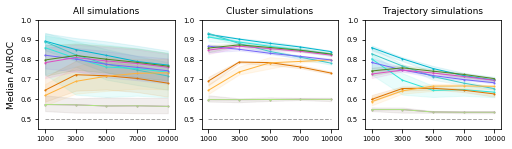

In [16]:
fig, axs = plt.subplots(1, 3)
fig.set_figheight(2)
fig.set_figwidth(8.29)
x = range(5)
for method, c, l in zip(methods, colours, labels):
    # overall auc_medians
    axs[0].plot(x, combined_medians.loc[:, method], linewidth=1, color=c, label=l)
    axs[0].scatter(x, combined_medians.loc[:, method], s=1, color=c, rasterized=True)
    axs[0].fill_between(range(5), combined_mins.loc[:, method],
                           combined_maxs.loc[:, method],
                           color=c, alpha=0.1)
    axs[0].set_ylabel("Median AUROC", fontsize=9)
    axs[0].set_title("All simulations", fontsize=9)
    # clusters combined_medians
    axs[1].plot(x, cluster_medians.loc[:, method], linewidth=1, color=c, label=l)
    axs[1].scatter(x, cluster_medians.loc[:, method], s=1,
                      color=c, rasterized=True)
    axs[1].fill_between(range(5), cluster_mins.loc[:, method],
                           cluster_maxs.loc[:, method],
                           color=c, alpha=0.1)
    axs[1].set_title("Cluster simulations", fontsize=9)
    # trajectory combined_medians
    axs[2].plot(x, trajectory_medians.loc[:, method], linewidth=1, color=c, label=l)
    axs[2].scatter(x, trajectory_medians.loc[:, method], s=1, color=c,
                      rasterized=True)
    plt.fill_between(range(5), trajectory_mins.loc[:, method],
                     trajectory_maxs.loc[:, method],
                     color=c, alpha=0.1)
    axs[2].set_title("Trajectory simulations", fontsize=9)
# leg = axs[2].legend(ncol=2, bbox_to_anchor=(.5, -.5), fancybox=False)
for ax in axs.ravel():
    ax.set_ylim(0.45, 1)
    ax.hlines(0.5, xmin=0, xmax=4, linewidth=1, color="#a5a5a5", ls="--",
              alpha=1)
    ax.set_yticks([.5, .6, .7, .8, .9, 1.])
    ax.set_yticklabels([.5, .6, .7, .8, .9, 1.], size=7)
    ax.set_xticks(x)
    ax.set_xticklabels([1000, 3000, 5000, 7000, 10000], size=7)

## 3. Compare times

### a. Load the times

In [17]:
with_p = ["SEMITONES_UMAP_rbf_p", "SEMITONES_UMAP_cosine_p",
          "SEMITONES_PCA_cosine_p"]
methods = methods + with_p

In [18]:
methods[10]

'SEMITONES_UMAP_rbf_p'

In [19]:
"_".join(methods[10].split("_")[0:3])

'SEMITONES_UMAP_rbf'

In [20]:
cluster_times = {}
trajectory_times = {}
for method in methods:
    if not method in ["MAST_unfiltered", "Wilcoxon_unfiltered"]:
        if "_p" in method:
            m = "_".join(method.split("_")[0:3])
            fname = f"groups_{m}_timesp.txt"
        else:
            fname = f"groups_{method}_times.txt"
        cluster_times[method] = pd.read_csv(fname, sep="\t"
                                           ).iloc[:, 1:6]
        if "_p" in method:
            m = "_".join(method.split("_")[0:3])
            fname = f"paths_{m}_timesp.txt"
        else:
            fname = f"paths_{method}_times.txt"
        trajectory_times[method] = pd.read_csv(fname, sep="\t"
                                              ).iloc[:, 1:6]
    else:
        for sim in ["groups", "paths"]:
            times = []
            rng = range(1, 5) if method == "MAST_unfiltered" else range(1, 4)
            for i in rng:
                fname = f"{sim}_{method}_times_it{i}.txt"
                t = pd.read_csv(fname, sep="\t", index_col=0).iloc[:, 1]
                times.append(t)
            times = pd.concat(times, axis=1).T
            times.columns, times.index = simulations, rng
            if sim == "paths":
                trajectory_times[method] = times
            else:
                cluster_times[method] = times

### b. Take median, min and max

#### i. Cluster simulations

In [21]:
cluster_times_medians = {k: v.median().values for k, v in cluster_times.items()}
cluster_times_medians = pd.DataFrame(cluster_times_medians)
cluster_times_medians.index = simulations

cluster_times_mins = {k: v.min().values for k, v in cluster_times.items()}
cluster_times_mins = pd.DataFrame(cluster_times_mins)
cluster_times_mins.index = simulations

cluster_times_maxs = {k: v.max().values for k, v in cluster_times.items()}
cluster_times_maxs = pd.DataFrame(cluster_times_maxs)
cluster_times_maxs.index = simulations

#### ii. Trajectory simulations

In [22]:
trajectory_times_medians = {k: v.median().values for k, v in trajectory_times.items()}
trajectory_times_medians = pd.DataFrame(trajectory_times_medians)
trajectory_times_medians.index = simulations
trajectory_times_mins = {k: v.min().values for k, v in trajectory_times.items()}
trajectory_times_mins = pd.DataFrame(trajectory_times_mins)
trajectory_times_mins.index = simulations
trajectory_times_maxs = {k: v.max().values for k, v in trajectory_times.items()}
trajectory_times_maxs = pd.DataFrame(trajectory_times_maxs)
trajectory_times_maxs.index = simulations

#### iii. Combined

In [23]:
combined_times = {}
for method in trajectory_times.keys():
    traj = trajectory_times[method]
    clust = cluster_times[method]
    times = pd.concat([clust, traj], axis=0)
    times.index, times.columns = range(times.shape[0]), simulations
    combined_times[method] = times

In [24]:
times_medians = {k: v.median().values for k, v in combined_times.items()}
times_medians = pd.DataFrame(times_medians)
times_medians.index = simulations
times_mins = {k: v.min().values for k, v in combined_times.items()}
times_mins = pd.DataFrame(times_mins)
times_mins.index = simulations
times_maxs = {k: v.max().values for k, v in combined_times.items()}
times_maxs = pd.DataFrame(times_maxs)
times_maxs.index = simulations

### e. Plot the times

Text(0.39, -0.05, 'Number of cells in simulation')

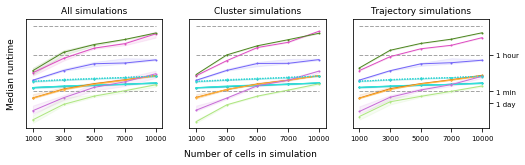

In [25]:
fig, axs = plt.subplots(1, 3)
fig.set_figheight(2)
fig.set_figwidth(8.29)
x = range(5)
for method, c, l in zip(methods, colours + colours[0:3],
                        labels + [None, None, None]):
    # overall times_medians
    ls = "dotted" if "_p" in method else "solid" 
    axs[0].plot(x, times_medians.loc[:, method], linewidth=1, color=c, label=l,
                ls=ls)
    axs[0].scatter(x, times_medians.loc[:, method], s=1, color=c, rasterized=True)
    axs[0].fill_between(range(5), times_mins.loc[:, method],
                           times_maxs.loc[:, method],
                           color=c, alpha=0.1)
    axs[0].set_ylabel("Median runtime", fontsize=9, labelpad=10)
    axs[0].set_title("All simulations", fontsize=9)
    # clusters times_medians
    axs[1].plot(x, cluster_times_medians.loc[:, method], linewidth=1, color=c,
                label=l, ls=ls)
    axs[1].scatter(x, cluster_times_medians.loc[:, method], s=1,
                      color=c, rasterized=True)
    axs[1].fill_between(range(5), cluster_times_mins.loc[:, method],
                           cluster_times_maxs.loc[:, method],
                           color=c, alpha=0.1)
    axs[1].set_title("Cluster simulations", fontsize=9)
    # trajectories times_medians
    axs[2].plot(x, trajectory_times_medians.loc[:, method], linewidth=1,
                color=c, label=l, ls=ls)
    axs[2].scatter(x, trajectory_times_medians.loc[:, method], s=1, color=c,
                      rasterized=True)
    plt.fill_between(range(5), trajectory_times_mins.loc[:, method],
                     trajectory_times_maxs.loc[:, method],
                     color=c, alpha=0.1)
    axs[2].set_title("Trajectory simulations", fontsize=9)
for ax in axs.ravel():
    ax.set_ylim(1, 60*60*24+100000)
    ax.hlines(60, xmin=0, xmax=4, linewidth=1, color="#a5a5a5", ls="--",
              alpha=1)
    ax.hlines(60*60, xmin=0, xmax=4, linewidth=1, color="#a5a5a5", ls="--",
          alpha=1)
    ax.hlines(60*60*24, xmin=0, xmax=4, linewidth=1, color="#a5a5a5", ls="--",
              alpha=1)
    ax.set_xticks(x)
    ax.set_xticklabels([1000, 3000, 5000, 7000, 10000], size=7)
    ax.set_yscale("log")
    ax.set_yticks([])
    ax.set_yticklabels([], size=7)
axs[2].yaxis.tick_right()
axs[2].set_yticks([60, 60*60, 60*60&24])
axs[2].set_yticklabels(["1 min", "1 hour", "1 day"], fontsize=7)
fig.text(0.39, -.05, "Number of cells in simulation", va="center", fontsize=9)